# Autoencoders and Generative Adversarial Networks
### XX Seminar on Software for Nuclear, Subnuclear and Applied Physics, 4-9 June 2023, Hotel Porto Conte, Maristella SS, IT

Contacts: 
 * email: Lucio.Anderlini [at] fi.infn.it
 * GitHub: [github.com/landerlini](https://github.com/landerlini)
 
## Systems of Neural Networks

So far we discussed of several examples of Neural Networks for several different tasks, spanning from Regression and Classification to more fancy tasks such as Density Estimation or Clustering.
In general, to train a Neural Network we need to define a loss function and tune the weights of the neural network to minimize that loss.

In this lecture we will try to face the problem of more advanced tasks where the loss itself is defined by means of a Neural Network. In this case we are training simultaneously two neural networks with the ambition of using one to inform the other. 

We call this approach "Systems of Neural Networks" and we will see some examples trying to make connections with applications in High Energy Physics.


## Autoencoders
The first example we consider is the training of a neural network on a dataset without labels. 

Obtaining labels is in general much more complicated than obtaining data. You can easily dump the internet to get Petabytes of photos almost for free, but you need to pay someone to carefully label those photos if you want to use them in training. 

Still, you may use that large sample of images to let the network to learn "how to see", and then use a much smaller dataset of labeled data to teach the network "what it seeing".



In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf

11490434/11490434 [==============================] - 0s 0us/step


40

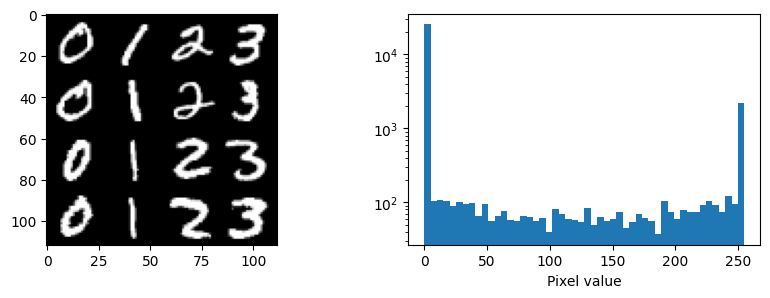

In [ ]:
def rough_inspection(dataset, n_fig=4):
    figure = np.concatenate([np.reshape(dataset[n_fig*i:n_fig*(i+1)], (n_fig*28, 28)) for i in range(n_fig)], axis=1)

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.imshow(figure, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(dataset.flatten(), bins=50)
    plt.yscale('log')
    plt.xlabel("Pixel value")
    plt.show()
    
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
train_idx = sum([np.arange(len(y_train))[y_train == i].tolist()[:4] for i in range(10)], [])
test_idx = sum([np.arange(len(y_test))[y_test == i].tolist()[:4] for i in range(10)], [])

Lx_train = x_train[train_idx]
Lx_test = x_test[test_idx]
Ly_train = y_train[train_idx]
Ly_test = y_test[test_idx]

display(len(Lx_train))
rough_inspection(Lx_train)

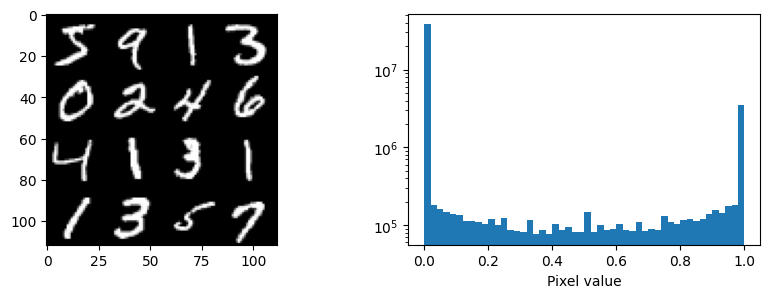

In [ ]:
px_train = (x_train / x_train.max())
px_test = (x_test / x_train.max()) 
pLx_train = (Lx_train / x_train.max())
pLx_test = (Lx_test / x_train.max()) 

py_train = np.stack([Ly_train == i for i in range(10)], axis=1)
py_test = np.stack([Ly_test == i for i in range(10)], axis=1)

rough_inspection(px_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 classifier (Dense)          (None, 10)                330       
                                                                 
Total params: 28,618
Trainable params: 28,618
Non-traina

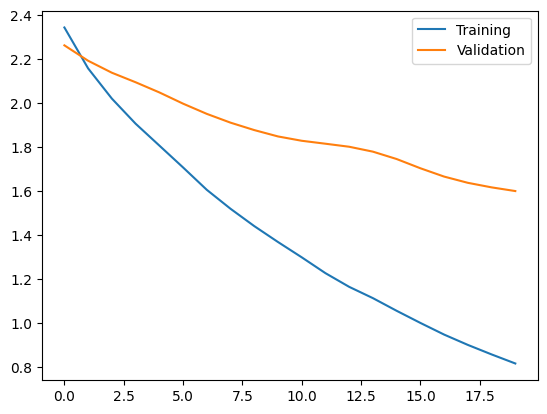

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
simple_classifier = Sequential([
    Flatten(),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(10, activation='softmax', name='classifier'),
])

simple_classifier.build(input_shape=(None, 28, 28))
simple_classifier.summary()

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
simple_classifier.compile(loss=CategoricalCrossentropy(), optimizer=Adam(1e-3))
history = simple_classifier.fit(pLx_train, py_train, validation_data=(pLx_test, py_test), epochs=20)

plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.legend()
plt.show()

2/2 [==============================] - 0s 10ms/step


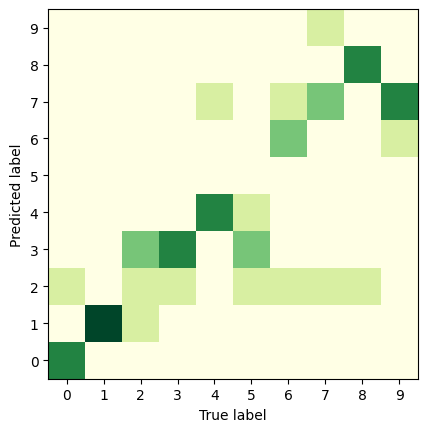

In [ ]:
from sklearn.metrics import confusion_matrix
py_test_hat = np.argmax(simple_classifier.predict(pLx_test), axis=1)
plt.imshow(confusion_matrix(py_test_hat, Ly_test), origin='lower', cmap="YlGn")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.regularizers import L2
autoencoder = Sequential([
    Flatten(),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh', name='latent_repr_32'),
    Dense(2, activation='linear', name='latent_repr_2'),     
    Dense(28//4*28//4, activation='tanh'),
    Reshape((28//4, 28//4, 1)),
    Conv2DTranspose(32, 3, activation='relu'),
    Conv2DTranspose(32, 3, activation='relu'),
    UpSampling2D(size=(4,4)),
    Conv2DTranspose(8, 3, activation='relu'),
    Conv2DTranspose(8, 3, activation='relu'),
    Flatten(),
    Dense(28*28, activation='sigmoid'),
    Reshape((28, 28))
])
autoencoder.build(input_shape=(None, 28, 28))

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
autoencoder.compile(loss=BinaryCrossentropy(), optimizer=Adam(3e-3))
history = autoencoder.fit(px_train, px_train, validation_data=(px_test[:128], px_test[:128]), epochs=50, batch_size=256)

plt.plot(history.history['loss'], label="Training data")
plt.plot(history.history['val_loss'], label="Validation data")

Epoch 1/50
162/235 [===================>..........] - ETA: 1:45 - loss: 0.2431

KeyboardInterrupt: ignored

313/313 [==============================] - 21s 67ms/step


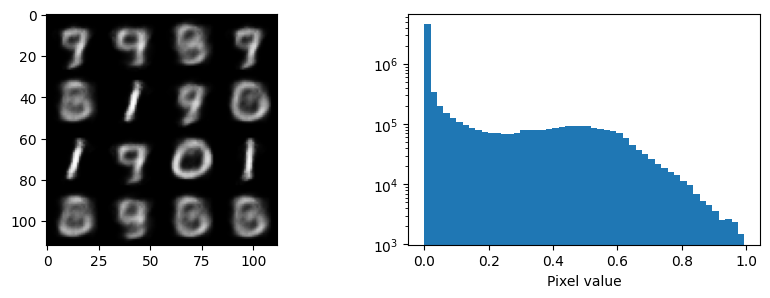

In [ ]:
reconstructed = autoencoder.predict(px_test)
rough_inspection(reconstructed)

313/313 [==============================] - 1s 1ms/step


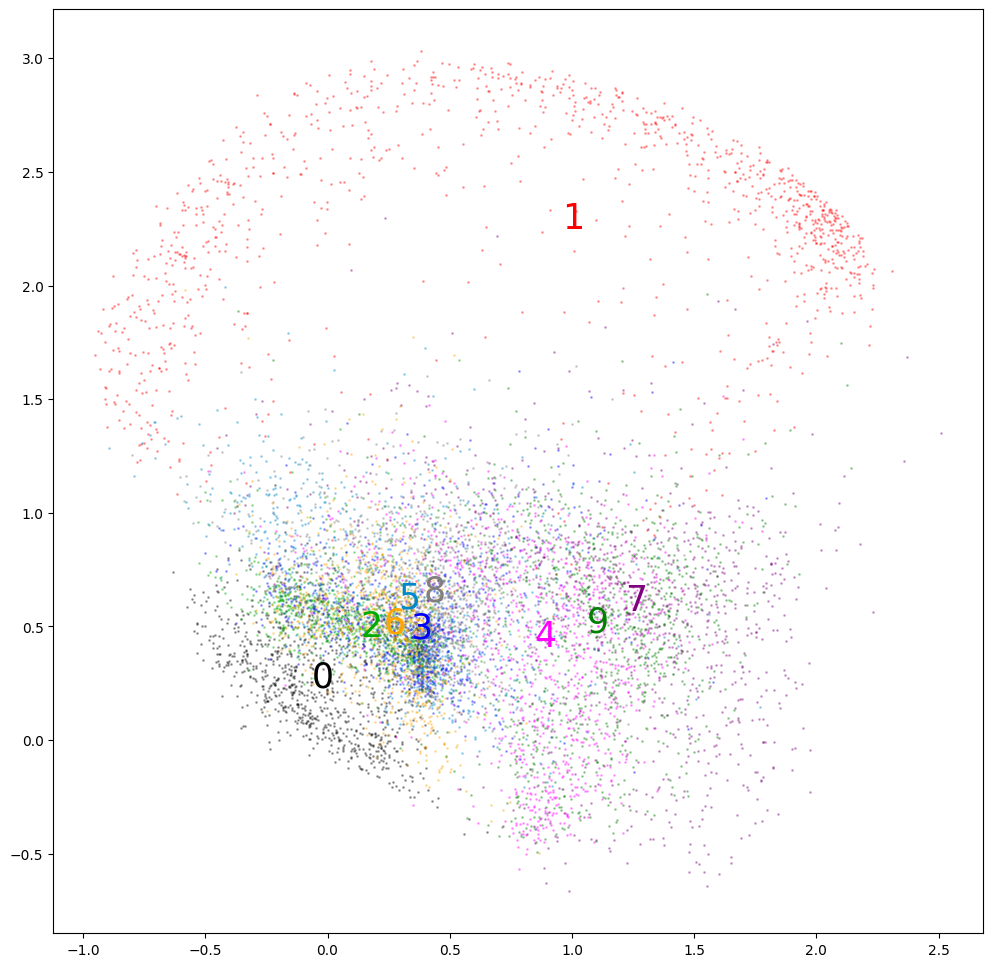

In [ ]:
encoder = Sequential()
for layer in autoencoder.layers:
  layer.trainable = False
  encoder.add(layer)
  if 'latent_repr_2' in layer.name:
    break

encoded_test = encoder.predict(px_test)
u, v = encoded_test.T
plt.figure(figsize=(12,12))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
  plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
  u_mean = np.quantile(u[y_test == digit], 0.5)
  v_mean = np.quantile(v[y_test == digit], 0.5)
  plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                25120     
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 latent_repr_32 (Dense)      (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 10)               

None

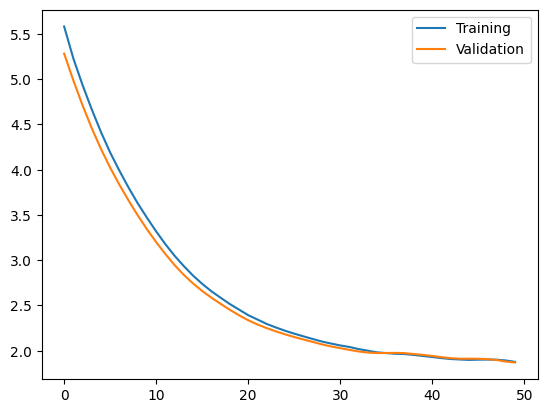

In [ ]:
trans_classifier = Sequential()
for layer in autoencoder.layers:
  layer.trainable = False
  trans_classifier.add(layer)
  if 'latent_repr_32' in layer.name:
    break

from tensorflow.keras.regularizers import L2
  
trans_classifier.add(Dense(32, activation='tanh', kernel_regularizer=L2(1e-1)))
trans_classifier.add(Dense(10, activation='softmax'))

n_labels = 128

from tensorflow.keras.losses import CategoricalCrossentropy
trans_classifier.compile(loss=CategoricalCrossentropy(), optimizer=Adam(5e-3))
history = trans_classifier.fit(
    pLx_train, py_train, 
    validation_data=(pLx_test, py_test), epochs=50, verbose=False)

display(trans_classifier.summary())


plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")

plt.legend()

2/2 [==============================] - 0s 5ms/step


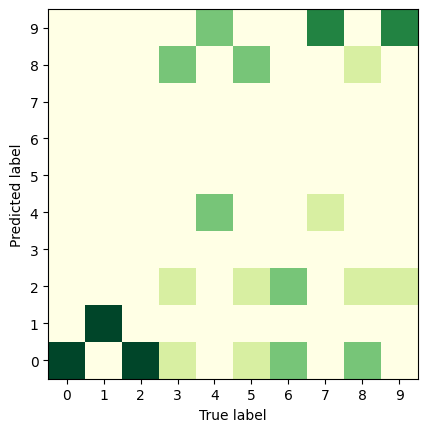

In [ ]:
from sklearn.metrics import confusion_matrix
py_test_hat = np.argmax(trans_classifier.predict(pLx_test), axis=1)
plt.imshow(confusion_matrix(py_test_hat, Ly_test), origin='lower', cmap="YlGn")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.show()

In [ ]:
!pip install -q emnist
import emnist
letters, _ = emnist.extract_training_samples('letters')
digits, _ = emnist.extract_training_samples('digits')

letters = letters/255
digits = digits/255

In [ ]:
recoed_digits = autoencoder.predict(digits)
recoed_letters = autoencoder.predict(letters)

1289/3900 [========>.....................] - ETA: 3:03

KeyboardInterrupt: ignored

In [ ]:
rough_inspection(digits[:64], n_fig=8)
rough_inspection(recoed_digits[:64], n_fig=8)
rough_inspection(recoed_digits[:64] - digits[:64], n_fig=8)

In [ ]:
rough_inspection(letters[:64], n_fig=8)
rough_inspection(recoed_letters[:64], n_fig=8)
rough_inspection(recoed_letters[:64] - letters[:64], n_fig=8)

In [ ]:
recoerr_digits = np.linalg.norm(recoed_digits - digits, axis=(1,2))
recoerr_letters = np.linalg.norm(recoed_letters - letters, axis=(1,2))
_, bins = np.histogram(np.concatenate((recoerr_digits, recoerr_letters)), bins=100)
plt.hist(recoerr_digits, bins=bins, label='Digits', histtype='step', linewidth=2, density=True)
plt.hist(recoerr_letters, bins=bins, label='Letters', histtype='step', linewidth=2, density=True)
plt.legend()
plt.show()

In [ ]:
anomalous_digits = np.argsort(recoerr_digits)[-64:]
rough_inspection(digits[anomalous_digits], n_fig=8)

anomalous_letters = np.argsort(recoerr_letters)[-64:]
rough_inspection(letters[anomalous_letters], n_fig=8)

In [ ]:
encoder = Sequential()
for layer in autoencoder.layers:
  layer.trainable = False
  encoder.add(layer)
  if 'latent_repr_2' in layer.name:
    break

encoded_test = encoder.predict(px_test)
encoded_letters = encoder.predict(letters)

u, v = encoded_test.T
plt.figure(figsize=(12,12))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
  plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
  u_mean = np.quantile(u[y_test == digit], 0.5)
  v_mean = np.quantile(v[y_test == digit], 0.5)
  plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

u, v = encoded_letters.T
plt.plot(u, v, 'o', color="yellow", markersize=1, alpha=0.1, zorder=-100)

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

encoder = Sequential([
    Reshape((28, 28, 1)),
    Conv2D(8, kernel_size=3, padding='same', activation='relu'),
    Conv2D(8, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(2, activation='linear')
])

encoder.build(input_shape=(None, 28, 28))
display(encoder.summary())

decoder = Sequential([
    Dense(32, activation='tanh'),
    Dense(28//4*28//4, activation='tanh'),
    Reshape((28//4, 28//4, 1)),
    Conv2DTranspose(32, kernel_size=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(32, kernel_size=(2, 2), padding='same', activation='relu'),
    UpSampling2D(size=(2 ,2)),
    Conv2DTranspose(16, kernel_size=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(16, kernel_size=(2, 2), padding='same', activation='relu'),
    UpSampling2D(size=(2 ,2)),
    Conv2DTranspose(8, kernel_size=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(1, kernel_size=(2, 2), padding='same', activation='sigmoid'),
    Reshape((28,28)),
])
decoder.build(input_shape=encoder.output_shape)

display(decoder.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        2320      
                                                      

None

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                96        
                                                                 
 dense_15 (Dense)            (None, 49)                1617      
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 1)           0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 7, 7, 32)         160       
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 7, 7, 32)         4128      
 ranspose)                                                       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 14, 14, 32)      

None

100%|██████████| 20/20 [43:23<00:00, 130.19s/it]


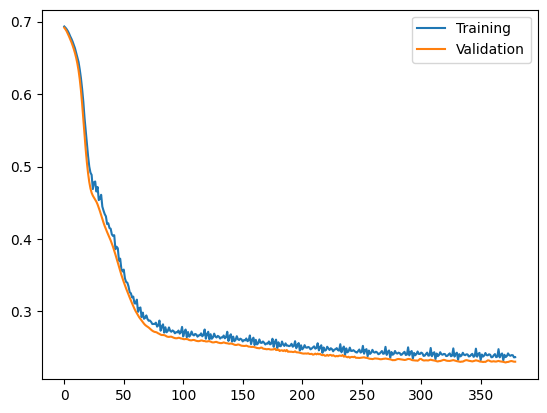

In [ ]:
ae_optimizer = Adam(1e-3)

def ae_train_step(train_data):
  enc_vars = encoder.trainable_weights
  dec_vars = decoder.trainable_weights

  ae_vars = enc_vars + dec_vars

  with tf.GradientTape() as tp:
    encoded = encoder(train_data)
    decoded = decoder(encoded)

    loss = BinaryCrossentropy()(train_data, decoded)

  ae_grads = tp.gradient(loss, ae_vars)
  ae_optimizer.apply_gradients(zip(ae_grads, ae_vars))

  return loss

def ae_test_step(test_data):
    encoded = encoder(test_data)
    decoded = decoder(encoded)

    loss = BinaryCrossentropy()(test_data, decoded)

    return loss


losses = []
val_losses = []
chunks = [tf.constant(c) for c in np.split(px_train, 20)[:-1]]
val_chunk = tf.constant(px_test[:1000])


## Reset the weights
from tensorflow.keras.models import clone_model
decoder = clone_model(decoder)
encoder = clone_model(encoder)

from tqdm import trange
for epoch in trange(20):
  for chunk in chunks:
    losses.append(ae_train_step(chunk))
    val_losses.append(ae_test_step(val_chunk))

plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

3900/3900 [==============================] - 5s 1ms/step


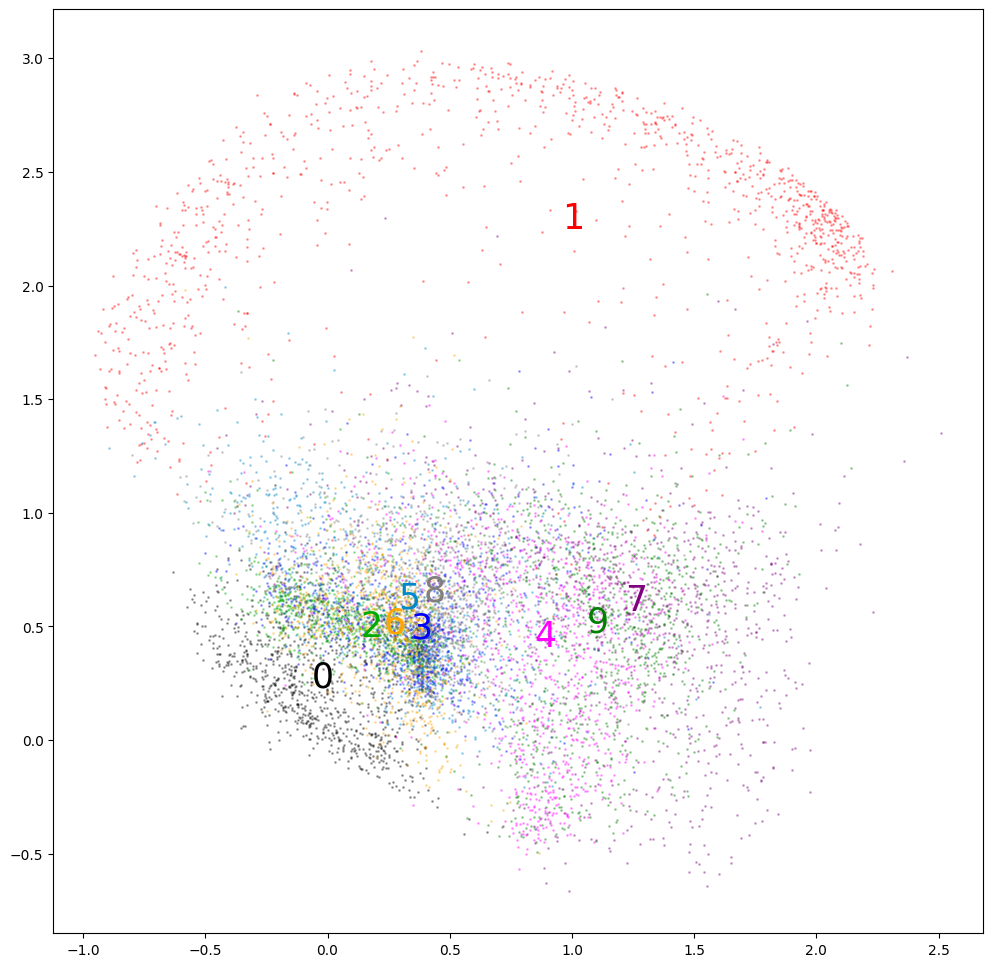

In [ ]:
encoder = Sequential()
for layer in autoencoder.layers:
  layer.trainable = False
  encoder.add(layer)
  if 'latent_repr_2' in layer.name:
    break

encoded_test = encoder.predict(px_test)
encoded_letters = encoder.predict(letters)

u, v = encoded_test.T
plt.figure(figsize=(12,12))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
  plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
  u_mean = np.quantile(u[y_test == digit], 0.5)
  v_mean = np.quantile(v[y_test == digit], 0.5)
  plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

plt.show()

100%|██████████| 20/20 [17:39<00:00, 53.00s/it]


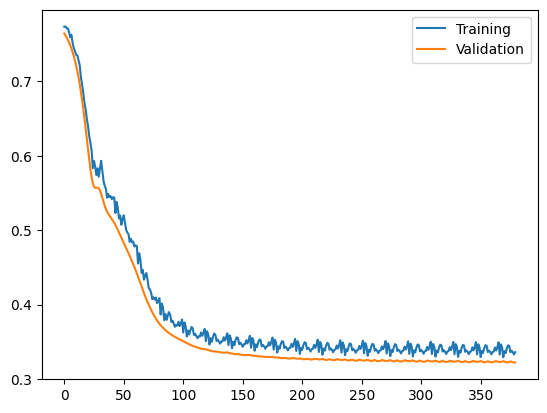

In [ ]:
ae_optimizer = Adam(1e-3)

def ae_train_step(train_data, labels):
  enc_vars = encoder.trainable_weights
  dec_vars = decoder.trainable_weights

  ae_vars = enc_vars + dec_vars

  with tf.GradientTape() as tp:
    encoded = encoder(train_data)
    decoded = decoder(encoded)

    theta = tf.atan2(encoded[:, 0], encoded[:, 1])
    labeled_loss = tf.reduce_mean(
        tf.where(tf.math.is_finite(labels), theta - labels/(10*2*np.pi), 0.)
    )

    loss = BinaryCrossentropy()(train_data, decoded) + 0.1 * labeled_loss

  ae_grads = tp.gradient(loss, ae_vars)
  ae_optimizer.apply_gradients(zip(ae_grads, ae_vars))

  return loss

def ae_test_step(test_data, labels):
    encoded = encoder(test_data)
    decoded = decoder(encoded)

    theta = tf.atan2(encoded[:, 0], encoded[:, 1])
    labeled_loss = tf.reduce_mean(
        tf.where(tf.math.is_finite(labels), theta - labels/(10*2*np.pi), 0.)
    )

    loss = BinaryCrossentropy()(test_data, decoded) + 0.1 * labeled_loss

    return loss


losses = []
val_losses = []
chunks = [tf.constant(c) for c in np.split(px_train, 20)[:-1]]
label_chunks = [tf.constant(c, dtype=tf.float32) for c in np.split(y_train, 20)[:-1]]

val_chunk = tf.constant(px_test[:1000])
val_label = tf.constant(y_test[:1000], dtype=tf.float32)


## Reset the weights
from tensorflow.keras.models import clone_model
decoder = clone_model(decoder)
encoder = clone_model(encoder)

from tqdm import trange
for epoch in trange(20):
  for chunk, label_chunk in zip(chunks, label_chunks):
    losses.append(ae_train_step(chunk, label_chunk))
    val_losses.append(ae_test_step(val_chunk, val_label))

plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

3900/3900 [==============================] - 6s 1ms/step


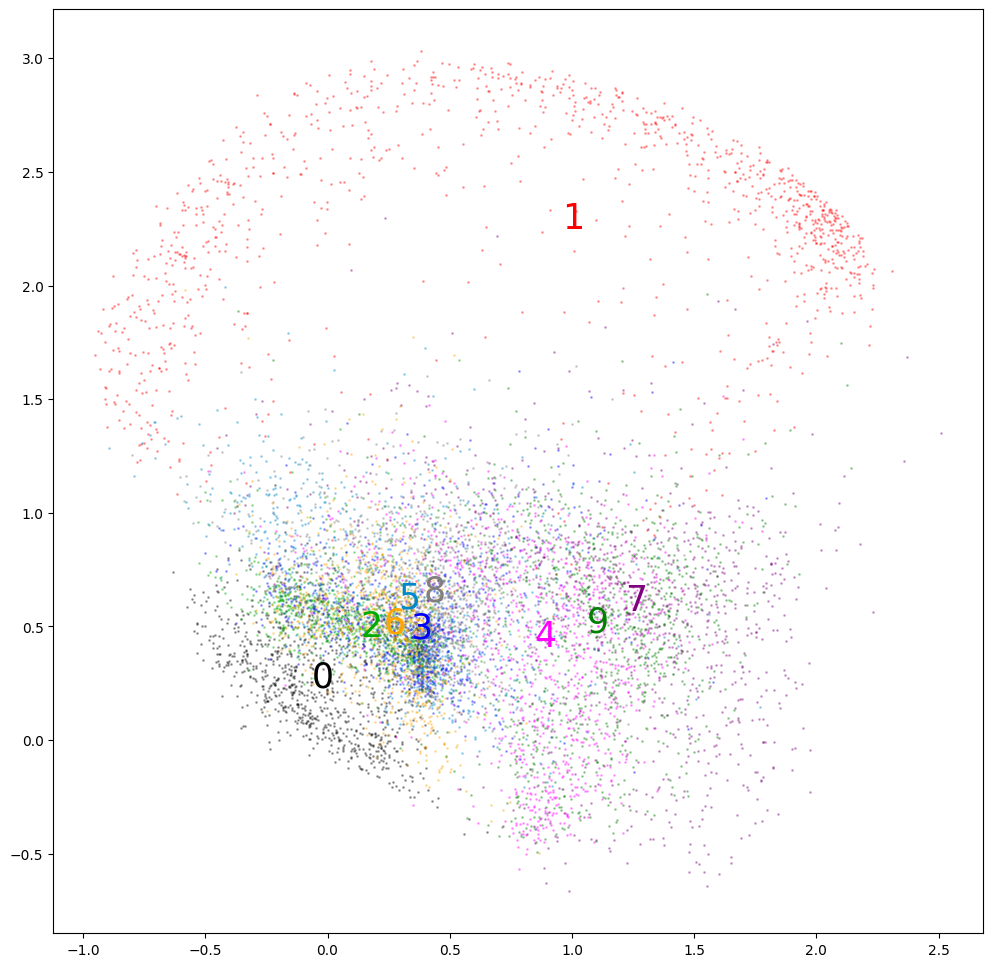

In [ ]:
encoder = Sequential()
for layer in autoencoder.layers:
  layer.trainable = False
  encoder.add(layer)
  if 'latent_repr_2' in layer.name:
    break

encoded_test = encoder.predict(px_test)
encoded_letters = encoder.predict(letters)

u, v = encoded_test.T
plt.figure(figsize=(12,12))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
  plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
  u_mean = np.quantile(u[y_test == digit], 0.5)
  v_mean = np.quantile(v[y_test == digit], 0.5)
  plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

plt.show()